# Predict number of goals in ice hockey games

This workbook explains how I built a machine learning model to predict if the number of goals in an ice hockey game will be over or under 5.5 goals. The reason for choosing that exact number is that this is the most frequently number you can bet on. 

I will work with data from ice hockey games in the 1st and 2nd league in Sweden (SHL and Hockeyallsvenskan). 
The process will look like this:
1. Import and explore data
2. Prepare data for modeling
3. Train model
4. Evaluate performance
5. Apply model to current season results 

So let's start!

### 1) Import and explore data
I will use a dataset I have put together through webscraping (origin: www.stats.swehockey.se) 
The packages to scrape this site for the data can be found in my [github project for ice-hockey-analysis](https://github.com/msjoelin/icehockey-analysis)


In [7]:
# Import packages
import numpy as np
import pandas as pd

# sklearn will be used to build the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from scipy.stats import kendalltau, pearsonr, spearmanr

# To save the model
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
notebook_path = os.path.abspath("game_prediction.ipynb")

In [2]:
# Import data from csv file
df_raw = pd.read_csv(os.path.join(os.path.dirname(notebook_path),"data/swehockey_game_trend.csv"))

print(df_raw.shape[0], " rows imported")

9184  rows imported


In [3]:
df_raw.columns

Index(['date', 'game', 'score', 'periodscore', 'spectators', 'schedule_id',
       'game_id', 'league', 'season', 'home', 'away', 'score_home',
       'score_away', 'p1score', 'p2score', 'p3score', 'p4score', 'p5score',
       'p1score_home', 'p1score_away', 'p2score_home', 'p2score_away',
       'p3score_home', 'p3score_away', 'p4score_home', 'p4score_away',
       'p5score_home', 'p5score_away', 'result', 'result_p1', 'result_p2',
       'result_p3', 'result_p4', 'result_p5', 'created', 'win_R5_home',
       'draw_R5_home', 'lost_R5_home', 'scored_avg_R5_home',
       'conceded_avg_R5_home', 'scored_cum_prev_avg_home',
       'conceded_cum_prev_avg_home', 'points_cum_prev_avg_home',
       'points_cum_h_a_prev_avg_home', 'H2H_W_home', 'H2H_D_home',
       'H2H_L_home', 'win_R5_away', 'draw_R5_away', 'lost_R5_away',
       'scored_avg_R5_away', 'conceded_avg_R5_away',
       'scored_cum_prev_avg_away', 'conceded_cum_prev_avg_away',
       'points_cum_prev_avg_away', 'points_cum_h_a_pr

The data set contains several columns. We will use data from previous matches, and fortunately there are metrics in the data set precalculated. 
Example : 
* conceded_cum_prev_avg: Average number of conceded goals per game, total entire season so far (excluding current game)
* points_cum_prev_avg_away: Average number of points per game for away team when playing away, total entire season so far (excluding current game)

Lets extract the relevant columns for us. For example, the period score or number of spectators are being left out.
Thereafter binary variables for our target variable is created. 

In [36]:
# Set relevant columns
relevant_cols = ['score', 'date', 'league', 'season', 'home', 'away', 'score_home', 'score_away',
                 'scored_avg_R5_home', 'conceded_avg_R5_home', 
                 'scored_cum_prev_avg_home', 'conceded_cum_prev_avg_home', 
                 'scored_avg_R5_away', 'conceded_avg_R5_away',
                 'scored_cum_prev_avg_away', 'conceded_cum_prev_avg_away',
                 'win_R5_home', 'draw_R5_home', 'lost_R5_home',
                 'win_R5_away', 'draw_R5_away', 'lost_R5_away',
                 'H2H_W_home', 'H2H_D_home', 'H2H_L_home', 
                 'points_cum_prev_avg_home', 'points_cum_prev_avg_away',
                 'points_cum_h_a_prev_avg_home', 'points_cum_h_a_prev_avg_away'
                ]

df_games = df_raw[relevant_cols].reset_index(drop=True)

# Define target column (total number of goals per game)
df_games['goals'] = df_games['score_home'] + df_games['score_away']
df_games = df_games.drop(['score_home', 'score_away'], axis=1)

# Introduce binary outcome variables if over 
df_games['goals_over_5'] = 0
df_games.loc[(df_games['goals']>5), 'goals_over_5'] = 1

df_games.describe()

,scored_avg_R5_home,conceded_avg_R5_home,scored_cum_prev_avg_home,conceded_cum_prev_avg_home,scored_avg_R5_away,conceded_avg_R5_away,scored_cum_prev_avg_away,conceded_cum_prev_avg_away,win_R5_home,draw_R5_home,...,lost_R5_away,H2H_W_home,H2H_D_home,H2H_L_home,points_cum_prev_avg_home,points_cum_prev_avg_away,points_cum_h_a_prev_avg_home,points_cum_h_a_prev_avg_away,goals,goals_over_5
count,9184.000000,9184.000000,9009.000000,9009.000000,9184.000000,9184.000000,9007.000000,9007.000000,9184.000000,9184.000000,...,9184.000000,9184.000000,9184.000000,9184.00000,9009.000000,9007.000000,8832.000000,8832.000000,9184.000000,9184.000000
mean,2.603061,2.657571,2.656266,2.683019,2.652134,2.596833,2.681612,2.655131,0.375528,0.209776,...,0.373214,0.363284,0.202434,0.38169,1.467175,1.493979,1.739727,1.218418,5.365309,0.414852
std,0.899425,0.913987,0.586097,0.605769,0.921188,0.894860,0.608752,0.582008,0.242882,0.195283,...,0.241922,0.227754,0.174017,0.23556,0.473430,0.476068,0.579692,0.566392,2.200685,0.492723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.307692,2.333333,2.000000,2.000000,2.333333,2.311806,0.200000,0.000000,...,0.200000,0.230769,0.071429,0.25000,1.181818,1.200000,1.409091,0.875000,4.000000,0.000000
50%,2.600000,2.600000,2.615385,2.641026,2.600000,2.600000,2.636364,2.625000,0.400000,0.200000,...,0.400000,0.363636,0.200000,0.37500,1.480769,1.500000,1.750000,1.214286,5.000000,0.000000
75%,3.200000,3.200000,2.954545,3.000000,3.200000,3.200000,2.974022,3.000000,0.600000,0.400000,...,0.600000,0.500000,0.285714,0.50000,1.750000,1.764706,2.090909,1.533333,7.000000,1.000000
max,8.000000,10.000000,8.000000,10.000000,10.000000,7.500000,10.000000,7.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,3.000000,3.000000,3.000000,3.000000,15.000000,1.000000


The last column ```goals_over_5``` shows that about 41% of the games ends up with more than 5 goals. 

There are some ```nan``` values that should be removed before modeling. 

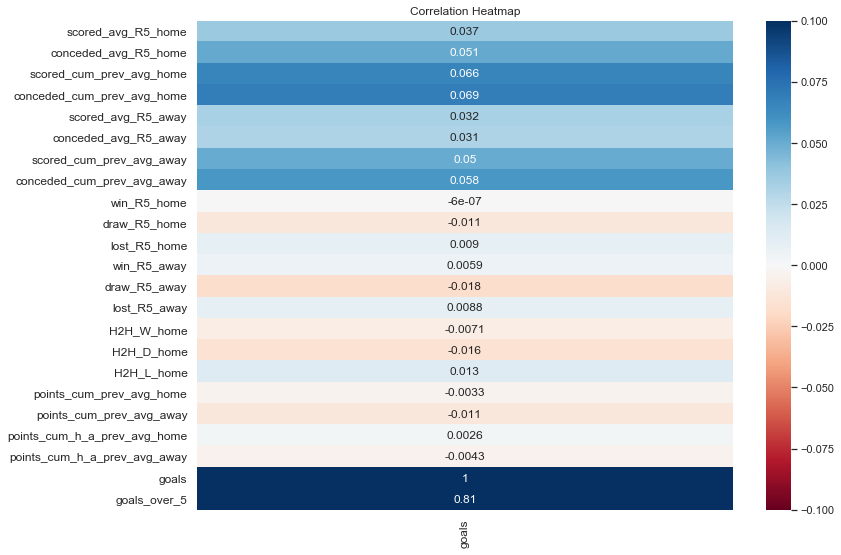

In [37]:
# Remove null values
df_games = df_games[~df_games.isnull().any(axis=1)].reset_index(drop=True)

# Heatmap for correlations
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_games.corr()[['goals']],
               annot = True, 
               cmap = 'RdBu',
               vmin = -0.1, 
               vmax = 0.1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows that - unsurprisingly - number of scored / conceded are the variables with highest correlation to number of goals in a game. Correlation for the home team is slightly higher, and the total scored goals over the season is also higher then the trend the last 5 games. 


### 2. Prepare data for modeling

The data for current season is saved to another dataframe, as this will be used to evaluate the final performance of the model and thus should not be used when training the model.

In [39]:
# Split data
df_2019 = df_games[df_games['season']=='2019/20']
df_model = df_games[df_games['season']!='2019/20'].reset_index(drop=True)

print("Data current season: " + str(df_2019.shape[0]))
print("Data for modeling: " + str(df_model.shape[0]))


Data current season: 697
Data for modeling: 8107


In [42]:
# Distribution of variable to be predicted
print('Distribution data in model')
print(df_model['goals_over_5'].value_counts(normalize=True))
print('Distribution data current season')
print(df_2019['goals_over_5'].value_counts(normalize=True))


Distribution data in model
0    0.584063
1    0.415937
Name: goals_over_5, dtype: float64
Distribution data current season
0    0.586801
1    0.413199
Name: goals_over_5, dtype: float64


Distribution is very similar the current season as before. 

#### Dependent and independent variables
Time to split our data into independent and dependent variables. 

In [57]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   score                         8107 non-null   object 
 1   date                          8107 non-null   object 
 2   league                        8107 non-null   object 
 3   season                        8107 non-null   object 
 4   home                          8107 non-null   object 
 5   away                          8107 non-null   object 
 6   conceded_avg_R5_home          8107 non-null   float64
 7   scored_cum_prev_avg_home      8107 non-null   float64
 8   conceded_cum_prev_avg_home    8107 non-null   float64
 9   points_cum_prev_avg_home      8107 non-null   float64
 10  scored_avg_R5_away            8107 non-null   float64
 11  conceded_avg_R5_away          8107 non-null   float64
 12  scored_cum_prev_avg_away      8107 non-null   float64
 13  con

The dependent variable (what should be predicted) is in column 28, and the independent variables are in columns 7 to 26. We save the attribute values in the variable ```info```.

Thereafter the data is splitted into train and test data (proportion 80/20).   
Considering our imbalanced data set, the input ``stratify =y`` is used. 
Finally the data is scaled so that all variables are weighted equal in the model. 

In [44]:
#Splitting the data into independent and dependent variables
X = df_model.iloc[:,7:27].values
y = df_model.iloc[:,28].values
info = df_model.iloc[:,0:6].values

X_2019 = df_2019.iloc[:,7:27].values
y_2019 = df_2019.iloc[:,28].values
info_2019 = df_2019.iloc[:,0:6].values

# Split in test and train data
X_train, X_test, y_train, y_test, info_train, info_test  = train_test_split(X, y, info, 
                                                                            test_size = 0.2, stratify = y, random_state = 21)
# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_2019 = scaler.transform(X_2019)

### 3. Train model

The data is prepared and ready to be modeled. 
I choose a standard randomforest classifier, 

In [45]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

# save the model to disk
filename = os.path.join(os.path.dirname(notebook_path),"ml_models/rf_predict_nbr_goals.sav")
pickle.dump(rf, open(filename, 'wb'))

### 4. Evaluate performance

Time to evaluate the performance of the model. We are looking at following metric:
* Precision: Proportion of positive predictions that was correct?
* Recall: Proportion of actual positives that was identified

In [46]:
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68       947
           1       0.43      0.21      0.28       675

    accuracy                           0.56      1622
   macro avg       0.51      0.51      0.48      1622
weighted avg       0.52      0.56      0.51      1622



Keep in mind that the overall probability that the number of goals would be under 5.5 is about 58%. 
This means that a "stupid" model would just suggest 0 as output all the time. Let's see what performance this model would give. 

In [60]:
# Create baseline array with only 0
y_pred_baseline = np.array([0] * y_pred_rf.size)

print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74       947
           1       0.00      0.00      0.00       675

    accuracy                           0.58      1622
   macro avg       0.29      0.50      0.37      1622
weighted avg       0.34      0.58      0.43      1622



C:\Users\marcu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comparing the output our model performs clearly better then the stupid one. 
We are identifying same number of games below 5.5, but still having a pretty decent identification of games above 5.5. Looks like the model might be useful on real data?

### 5. Apply model to current season results

So let us now apply the model to the game this current season. This data was not part of the training data, so overfitting will not be an issue when evaluating performance. We will also estimate if this model would bring any money if we would have used it over the entire season. 

In [106]:
y_pred2019_rf = rf.predict(X_2019)
y_pred2019_rf_prob = rf.predict_proba(X_2019)

# Baseline model: Only 0 all the time
y_pred2019_baseline = np.array([0] * y_pred2019_rf.size)

# Create dataframe with data for 2019
df_2019 = pd.DataFrame(info_2019)
df_2019.columns = ["score", "date", "league", "season", "home","away"]

# Set the outcome variables and probabilities
df_2019['actual'] = y_2019
df_2019['predicted'] = y_pred2019_rf
df_2019['baseline'] = y_pred2019_baseline

df_2019['correct']=0
df_2019.loc[df_2019['actual']==df_2019['predicted'],'correct']=1
df_2019['prob_under']=y_pred2019_rf_prob[:,0]
df_2019['prob_over']=y_pred2019_rf_prob[:,1]

df_2019['correct_baseline']=0
df_2019.loc[df_2019['actual']==df_2019['baseline'],'correct_baseline']=1

df_2019.head()

,score,date,league,season,home,away,actual,predicted,baseline,correct,prob_under,prob_over,correct_baseline
0,4 - 2,2019-09-19,shl,2019/20,Djurgårdens IF,Örebro HK,1,1,0,1,0.32,0.68,0
1,4 - 2,2019-09-19,shl,2019/20,Färjestad BK,Växjö Lakers HC,1,1,0,1,0.48,0.52,0
2,4 - 0,2019-09-19,shl,2019/20,Frölunda HC,Linköping HC,0,0,0,1,0.70,0.30,1
3,3 - 2,2019-09-19,shl,2019/20,Luleå HF,HV 71,0,0,0,1,0.68,0.32,1
4,0 - 1,2019-09-19,shl,2019/20,Rögle BK,IK Oskarshamn,0,0,0,1,0.56,0.44,1


In [107]:
# Check mean values by sign
print(df_2019.groupby(['predicted'])['actual'].count())
print(df_2019.groupby(['baseline'])['actual'].count())

predicted
0    561
1    136
Name: actual, dtype: int64
baseline
0    697
Name: actual, dtype: int64


I dont have any historical odds data for over/under results, but looking at my betting history a "normal" odds above 5.5 is around 2.2. Keep in mind I probably picked out odds which were high, so lets set a typical odds to 2.1 above and 1.6 below. 
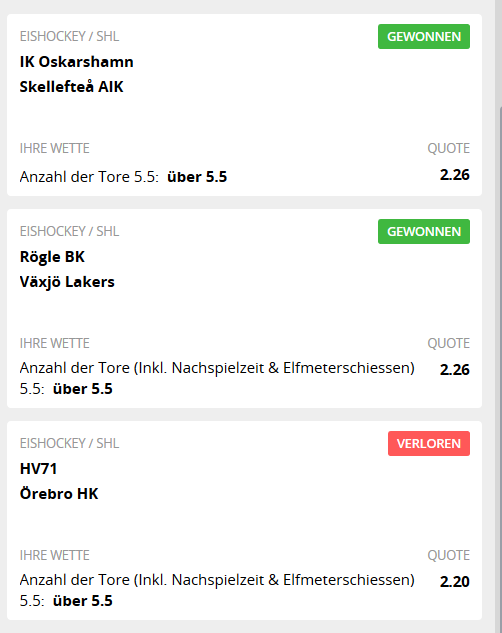

In [108]:
odds_under = 1.6
odds_over = 2.3

df_2019['odds_under'] = odds_under
df_2019['odds_over'] = odds_over

df_2019['odds_outcome'] = odds_under
df_2019.loc[df_2019['actual']==1,'odds_outcome'] = odds_over

df_2019['stake'] = 1
df_2019['return'] = df_2019['odds_outcome']*df_2019['correct']*df_2019['stake'] - df_2019['stake']
df_2019['return_baseline'] = df_2019['odds_outcome']*df_2019['correct_baseline']*df_2019['stake'] - df_2019['stake']

df_2019.head()

,score,date,league,season,home,away,actual,predicted,baseline,correct,prob_under,prob_over,correct_baseline,odds_under,odds_over,odds_outcome,stake,return,return_baseline
0,4 - 2,2019-09-19,shl,2019/20,Djurgårdens IF,Örebro HK,1,1,0,1,0.32,0.68,0,1.6,2.3,2.3,1,1.3,-1.0
1,4 - 2,2019-09-19,shl,2019/20,Färjestad BK,Växjö Lakers HC,1,1,0,1,0.48,0.52,0,1.6,2.3,2.3,1,1.3,-1.0
2,4 - 0,2019-09-19,shl,2019/20,Frölunda HC,Linköping HC,0,0,0,1,0.70,0.30,1,1.6,2.3,1.6,1,0.6,0.6
3,3 - 2,2019-09-19,shl,2019/20,Luleå HF,HV 71,0,0,0,1,0.68,0.32,1,1.6,2.3,1.6,1,0.6,0.6
4,0 - 1,2019-09-19,shl,2019/20,Rögle BK,IK Oskarshamn,0,0,0,1,0.56,0.44,1,1.6,2.3,1.6,1,0.6,0.6


In [109]:
#print(df_2019.groupby(['actual'])['return'].sum())
#print(df_2019.groupby(['actual'])['return_baseline'].sum())

print(df_2019.groupby(['predicted'])['return'].sum())
print(df_2019.groupby(['baseline'])['return_baseline'].sum())

predicted
0   -33.0
1    -4.9
Name: return, dtype: float64
baseline
0   -42.6
Name: return_baseline, dtype: float64


In [110]:
df_2019.to_csv("C:/Users/marcu/Documents/Python/icehockey/data/df_2019_nbr_goals.csv", index=False)